### Can you generate faces?
##### We expect you to use images to generate new ones with a Generative Model of your choice. You have to write a dataloader to read images from the folder 'faces/', write a Generative Model class, a loss function, a training loop, and visualize your generated images.

In [2]:
import os
import torch
import torch.nn as nn
import matplotlib.image as mpimg
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import imageio as Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Lambda

from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np

%matplotlib inline

### Nothing to change here (This cell downloads and unzips the data).

In [3]:
!wget https://www.dropbox.com/s/g0w7a3x1aw3oonf/SimpsonFaces.zip?dl=0

!unzip SimpsonFaces.zip?dl=0

!ls

Streaming af output blev afkortet til de sidste 5000 linjer.
  inflating: __MACOSX/cropped/._4084.png  
  inflating: cropped/3933.png        
  inflating: __MACOSX/cropped/._3933.png  
  inflating: cropped/2393.png        
  inflating: __MACOSX/cropped/._2393.png  
  inflating: cropped/1842.png        
  inflating: __MACOSX/cropped/._1842.png  
  inflating: cropped/4912.png        
  inflating: __MACOSX/cropped/._4912.png  
  inflating: cropped/326.png         
  inflating: __MACOSX/cropped/._326.png  
  inflating: cropped/440.png         
  inflating: __MACOSX/cropped/._440.png  
  inflating: cropped/9588.png        
  inflating: __MACOSX/cropped/._9588.png  
  inflating: cropped/8696.png        
  inflating: __MACOSX/cropped/._8696.png  
  inflating: cropped/6863.png        
  inflating: __MACOSX/cropped/._6863.png  
  inflating: cropped/454.png         
  inflating: __MACOSX/cropped/._454.png  
  inflating: cropped/8682.png        
  inflating: __MACOSX/cropped/._8682.png  
  inflat

## Dataloader
####  Write a dataloader to read images from the folder 'faces/' (Note that the transform *trans* resizes the images to 32x32)

In [4]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([32,32])])

# Replace the question marks '?' by the necessary code
batch_size = 64

class MyDataset(Dataset):
  def __init__(self, image_path, transform = trans):
    self.image_path = image_path
    self.images = os.listdir(image_path)
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    im = self.images[idx]
    im = mpimg.imread(os.path.join(self.image_path, im))
    im = self.transform(im)
    return im

In [5]:
dataset = MyDataset("/content/cropped")

train_loader = DataLoader(dataset, batch_size = batch_size)

#### Visualize the data
##### Get a batch from the dataloader and visualize its images

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dataloader output shape:  torch.Size([64, 3, 32, 32])


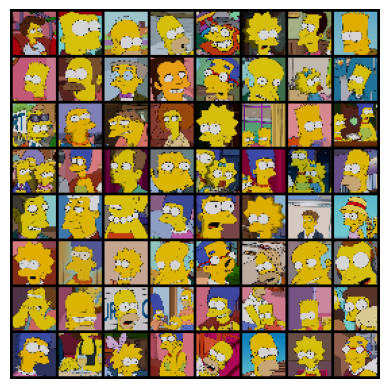

In [6]:
# Make sure our data loader has outputs right shape
data_iter = next(iter(train_loader))
print('Dataloader output shape: ', data_iter.size())

# Visualizing sample images from one batch
from torchvision.utils import make_grid
samples = data_iter
grid_img = make_grid(samples, nrow=8)
plt.figure()
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()


### Generative Model class
#### Write a Generative Model class in the following cell

In [76]:
EPOCHS = 5000
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
TIME_EMBEDDING_DIM = 100
TIMESTAMPS = 1000
# check if gpu is available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

A diffusion model has been chosen for face generation.

Some initial building blocks in our model is defined

In [77]:
# We define some basic model blocks here which we will utilize later in our model.
class ConvBlock(nn.Module):
  """Convolution Block."""
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, time_emb_dim, last=False):
    super(ConvBlock, self).__init__()
    self.last = last
    self.time_mlp = nn.Linear(time_emb_dim, in_channels)
    self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    if not self.last:
      self.batch_norm_layer = nn.BatchNorm2d(out_channels)
      self.act = nn.LeakyReLU()

  def forward(self, x, t):
    t = self.time_mlp(t)
    x = x + t.view(*t.shape, 1, 1)
    x = self.conv_layer(x)
    if not self.last:
      x = self.batch_norm_layer(x)
      x = self.act(x)
    return x


class UpSampleBlock(nn.Module):
  """Up Sampling Block."""
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding, time_emb_dim, last=False):
    super(UpSampleBlock, self).__init__()
    self.last = last
    self.time_mlp = nn.Linear(time_emb_dim, in_channels)
    self.conv_trans_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding)
    if not self.last:
      self.batch_norm_layer = nn.BatchNorm2d(out_channels)
      self.act = nn.LeakyReLU()

  def forward(self, x, t):
    t = self.time_mlp(t)
    x = x + t.view(*t.shape, 1, 1)
    x = self.conv_trans_layer(x)
    if not self.last:
      x = self.batch_norm_layer(x)
      x = self.act(x)
    return x


class LinearBlock(nn.Module):
  """Linear Block."""
  def __init__(self, in_dim, out_dim, time_emb_dim):
    super(LinearBlock, self).__init__()
    self.time_mlp = nn.Linear(time_emb_dim, in_dim)
    self.linear_layer = nn.Linear(in_dim, out_dim)
    self.batch_norm_layer = nn.BatchNorm1d(out_dim)
    self.act = nn.LeakyReLU()

  def forward(self, x, t):
    t = self.time_mlp(t)
    x = x + t
    x = self.linear_layer(x)
    x = self.batch_norm_layer(x)
    x = self.act(x)
    return x


class SinusoidalPositionEmbeddings(nn.Module):
    """Encode timestep to dim dimensional vector"""
    def __init__(self, dim):
      super(SinusoidalPositionEmbeddings, self).__init__()
      self.dim = dim

    def forward(self, time):
      device = time.device
      half_dim = self.dim // 2
      embeddings = np.log(10000) / (half_dim - 1)
      embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
      embeddings = time[:, None] * embeddings[None, :]
      embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

      return embeddings


In [78]:
class Reshape(nn.Module):
  """A custom reshape layer."""
  def __init__(self, shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(*self.shape)


class DiffusionModel(nn.Module):
  """Diffusion model"""
  def __init__(self, time_emb_dim):
    super(DiffusionModel, self).__init__()
    self.time_emb_dim = time_emb_dim

    self.time_embedding_model = nn.Sequential(
        SinusoidalPositionEmbeddings(200),
        nn.Linear(200, time_emb_dim),
        nn.LeakyReLU(),
        nn.Linear(time_emb_dim, time_emb_dim)
    )
    # check this input channel = 3 for RGB input?
    self.dsb_1 = ConvBlock(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=2, time_emb_dim=time_emb_dim)
    self.conv1 = ConvBlock(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
    self.dsb_2 = ConvBlock(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, time_emb_dim=time_emb_dim)
    self.conv2 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
    self.dsb_3 = ConvBlock(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1, time_emb_dim=time_emb_dim)

    self.flatten = nn.Flatten(1,-1)

    self.linear_1 = LinearBlock(in_dim=512*4*4, out_dim=256, time_emb_dim=time_emb_dim)
    self.linear_2 = LinearBlock(in_dim=256, out_dim=128, time_emb_dim=time_emb_dim)

    self.linear_3 = LinearBlock(in_dim=128, out_dim=256, time_emb_dim=time_emb_dim)
    self.linear_4 = LinearBlock(in_dim=256, out_dim=512*4*4, time_emb_dim=time_emb_dim)

    self.reshape = Reshape((-1,512,4,4))

    self.usb_1 = UpSampleBlock(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1, time_emb_dim=time_emb_dim)
    self.conv3 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
    self.usb_2 = UpSampleBlock(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, time_emb_dim=time_emb_dim)
    self.conv4 = ConvBlock(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
    self.usb_3 = UpSampleBlock(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=2, output_padding=1, time_emb_dim=time_emb_dim)
    self.conv5 = ConvBlock(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0, time_emb_dim=time_emb_dim, last=True)
    # check this output channel = 3 for RGB output?

    #self.reshape_out = Reshape((-1,3,32,32))

  def forward(self, x, t):
    t = self.time_embedding_model(t)
    x1 = self.dsb_1(x, t)
    x2 = self.conv1(x1, t)
    x3 = self.dsb_2(x2, t)
    x4 = self.conv2(x3, t)
    x5 = self.dsb_3(x4, t)

    x5_ = self.flatten(x5)
    x6 = self.linear_1(x5_, t)
    x7 = self.linear_2(x6, t)
    x = self.linear_3(x7, t)
    x = self.linear_4(x+x6, t)
    x = self.reshape(x)

    #print('check sizes 1', x.size(), x5.size(), t.size())
    x = self.usb_1(x+x5, t)
    #print('check sizes 2', x.size(), x4.size(), t.size())
    x = self.conv3(x+x4, t)
    x = self.usb_2(x+x3, t)
    x = self.conv4(x+x2, t)
    x = self.usb_3(x+x1, t)
    x = self.conv5(x, t)

    #x = self.reshape_out(x)
    return x


model = DiffusionModel(time_emb_dim=TIME_EMBEDDING_DIM)
model = model.to(device)
#summary(model,input_size=(3,32,32))

In [79]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# define beta schedule
betas = linear_beta_schedule(timesteps=TIMESTAMPS)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = nn.functional.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [80]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

## Loss
#### Define Loss function in the following cell

In [81]:
def p_losses(denoise_model, x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    loss = nn.functional.smooth_l1_loss(noise, predicted_noise.reshape(3,32,32))

    return loss

### Training Loop
#### Define optimizer, write the training loop in the following cell, and plot the loss

In [82]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Training loop
train_loss_epoch = []
for i in range(1,EPOCHS+1):
  running_loss = 0
  #pbar = tqdm(train_loader)
  pbar = next(iter(train_loader))

  print("Epoch: {}".format(i))
  for b, data in enumerate(pbar):
    # Every data instance is an input + label pair. We don't need the label
    inputs  = data
    inputs = inputs.to(device)

    #inputs = inputs.mean(0).reshape(1,32,32)
    # Zero the gradients for every batch!
    optimizer.zero_grad()

    t = torch.randint(0, TIMESTAMPS, (inputs.shape[0],), device=device).long()

    # Compute the loss and its gradients
    loss = p_losses(model, inputs, t)
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Update Progress
    running_loss += loss.item()
    #pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
    #pbar.set_postfix({"batch_loss": loss.item(), "avg_loss": running_loss/(b+1)})
  print("Train Loss: {:.3f}.. ".format(running_loss))
  train_loss_epoch.append(running_loss)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Streaming af output blev afkortet til de sidste 5000 linjer.
Epoch: 2501
Train Loss: 8.622.. 
Epoch: 2502
Train Loss: 9.061.. 
Epoch: 2503
Train Loss: 8.650.. 
Epoch: 2504
Train Loss: 8.049.. 
Epoch: 2505
Train Loss: 9.949.. 
Epoch: 2506
Train Loss: 10.604.. 
Epoch: 2507
Train Loss: 9.410.. 
Epoch: 2508
Train Loss: 8.042.. 
Epoch: 2509
Train Loss: 9.395.. 
Epoch: 2510
Train Loss: 8.415.. 
Epoch: 2511
Train Loss: 7.991.. 
Epoch: 2512
Train Loss: 7.478.. 
Epoch: 2513
Train Loss: 8.937.. 
Epoch: 2514
Train Loss: 7.992.. 
Epoch: 2515
Train Loss: 7.672.. 
Epoch: 2516
Train Loss: 9.958.. 
Epoch: 2517
Train Loss: 8.883.. 
Epoch: 2518
Train Loss: 8.968.. 
Epoch: 2519
Train Loss: 8.416.. 
Epoch: 2520
Train Loss: 8.158.. 
Epoch: 2521
Train Loss: 12.979.. 
Epoch: 2522
Train Loss: 8.326.. 
Epoch: 2523
Train Loss: 9.271.. 
Epoch: 2524
Train Loss: 10.236.. 
Epoch: 2525
Train Loss: 9.112.. 
Epoch: 2526
Train Loss: 9.184.. 
Epoch: 2527
Train Loss: 9.396.. 
Epoch: 2528
Train Loss: 7.226.. 
Epoch: 2529


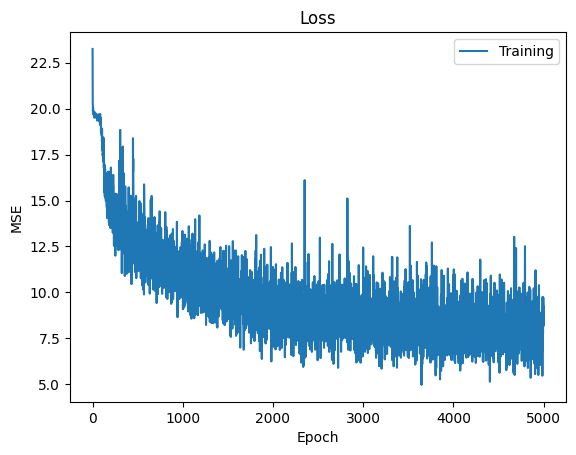

In [83]:
# visualisi loss scores
plt.title('Loss')
plt.plot(train_loss_epoch, label = 'Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

## Generate and Plot Data
#### Generate a batch of 64 images and plot them in subplots of 8 rows and 8 columns.

In [84]:
# ADD CODE HERE
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, TIMESTAMPS)), desc='sampling loop time step', total=TIMESTAMPS):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=64, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))



In [85]:

# sample 64 images
samples = sample(model, image_size=32, batch_size=64, channels=3)

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 183.12it/s]


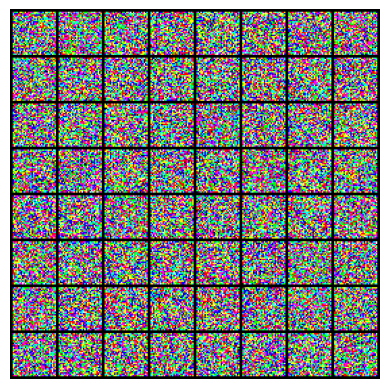

In [86]:
samples_tensor = torch.from_numpy(np.array(samples[-1]))

# Visualizing sample images from one batch
grid_img = make_grid(samples_tensor, nrow=8)
plt.figure()
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()
